In [164]:
!pip install emoji
!pip install fasttext
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install flask
!pip install scikit-learn

^C
ERROR: Operation cancelled by user


In [165]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify
import io

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [166]:
vocab_size = 2957
embedding_dim = 300
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 800
num_epochs = 20

In [167]:
sentences = []
labels = []

# Load the dataset
url = "https://raw.githubusercontent.com/RusiruWijethilake/DepFlow/main/new_dataset.csv"
df = pd.read_csv(url)

df = df.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe
for x in range(len(df)):
    sentences.append(df.iloc[x][0])
    labels.append(df.iloc[x][1])

In [168]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [169]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print(len(word_index))

print(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

3737
{'<OOV>': 1, 'මට': 2, 'මම': 3, 'කරන්න': 4, 'නෑ': 5, 'වෙලා': 6, 'කියලා': 7, 'එක': 8, 'එපා': 9, 'මන්': 10, 'මේ': 11, 'ගොඩක්': 12, 'ඒ': 13, 'මගේ': 14, 'මං': 15, 'දැන්': 16, 'හිතෙනවා': 17, 'ඉන්න': 18, 'නිසා': 19, 'ගන්න': 20, 'කෙනෙක්': 21, 'වගේ': 22, 'ගැන': 23, 'වෙන්න': 24, 'ඒත්': 25, 'දේවල්': 26, 'ජීවිතේ': 27, 'ඉන්නේ': 28, 'හරි': 29, 'කරන': 30, 'යන්න': 31, 'නම්': 32, 'එක්ක': 33, 'වෙනවා': 34, 'ඒක': 35, 'හිත': 36, 'නැති': 37, 'ආදරේ': 38, 'එහෙම': 39, 'කතා': 40, 'මාව': 41, 'දෙයක්': 42, 'මානසික': 43, 'බෑ': 44, 'ලොකු': 45, 'ඕන': 46, 'ඔබ': 47, 'තියෙන්නේ': 48, 'නැ': 49, 'එයා': 50, 'බැරි': 51, 'නැහැ': 52, 'කියල': 53, 'දෙන්න': 54, 'උනා': 55, 'වෙන': 56, 'ඇති': 57, 'දේ': 58, 'ගොඩාක්': 59, 'කරලා': 60, 'මේක': 61, 'එකක්': 62, 'පුලුවන්': 63, 'කොහොමද': 64, 'හැම': 65, 'කියන': 66, 'කියන්න': 67, 'වේදනාව': 68, 'අය': 69, 'තියෙනවා': 70, 'වෙයි': 71, 'වෙනස්': 72, 'ඇයි': 73, 'වඩා': 74, 'ඇත්තටම': 75, 'පාඩම්': 76, 'කරනවා': 77, 'ඉන්නෙ': 78, 'සමහර': 79, 'කිසිම': 80, 'මොකද': 81, 'හොද': 82, 'කර': 83, 'ගෙදර': 84, 'වැ

In [170]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [171]:
import fasttext.util

# Load FastText model
ft = fasttext.load_model("cc.si.300.bin")

# Get embedding dimensions
embedding_dim = ft.get_dimension()

# Mapping FastText word vectors with word in the dataset
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [172]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(128, dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 300)           1121400   
                                                                 
 lstm_10 (LSTM)              (None, 128)               219648    
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,341,177
Trainable params: 219,777
Non-trainable params: 1,121,400
_________________________________________________________________


In [173]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(training_padded, training_labels, epochs=num_epochs, batch_size=32, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[checkpoint])

Epoch 1/20
25/25 - 5s - loss: 0.6588 - accuracy: 0.6375 - val_loss: 0.5548 - val_accuracy: 0.7220 - 5s/epoch - 199ms/step
Epoch 2/20
25/25 - 1s - loss: 0.5527 - accuracy: 0.7050 - val_loss: 0.5070 - val_accuracy: 0.7415 - 635ms/epoch - 25ms/step
Epoch 3/20
25/25 - 0s - loss: 0.5122 - accuracy: 0.7500 - val_loss: 0.4845 - val_accuracy: 0.7902 - 451ms/epoch - 18ms/step
Epoch 4/20
25/25 - 0s - loss: 0.4733 - accuracy: 0.7663 - val_loss: 0.4806 - val_accuracy: 0.7659 - 416ms/epoch - 17ms/step
Epoch 5/20
25/25 - 0s - loss: 0.4786 - accuracy: 0.7650 - val_loss: 0.4891 - val_accuracy: 0.7756 - 437ms/epoch - 17ms/step
Epoch 6/20
25/25 - 0s - loss: 0.4407 - accuracy: 0.7987 - val_loss: 0.5021 - val_accuracy: 0.7415 - 415ms/epoch - 17ms/step
Epoch 7/20
25/25 - 0s - loss: 0.4535 - accuracy: 0.8000 - val_loss: 0.4979 - val_accuracy: 0.8000 - 431ms/epoch - 17ms/step
Epoch 8/20
25/25 - 0s - loss: 0.4369 - accuracy: 0.7700 - val_loss: 0.5401 - val_accuracy: 0.7171 - 408ms/epoch - 16ms/step
Epoch 9/20

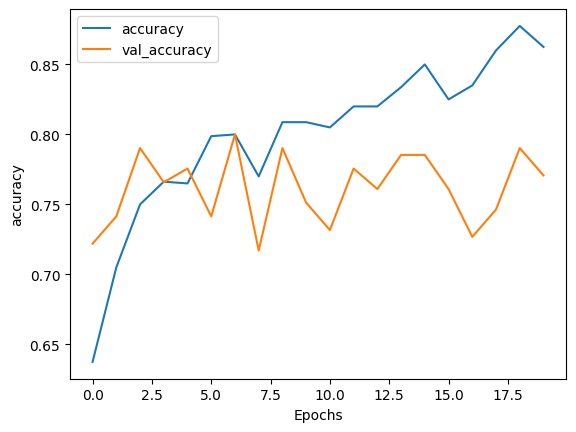

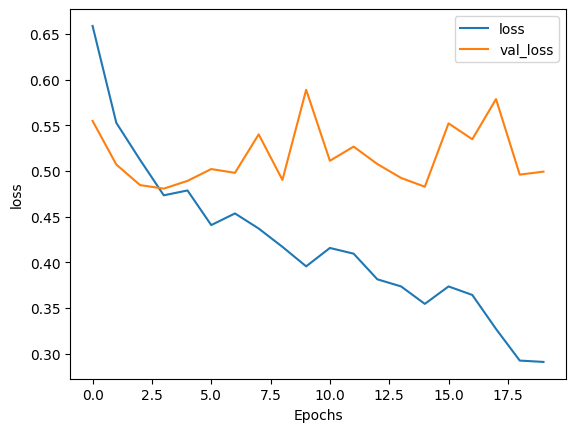

In [174]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [175]:
# Model Evaluation
eval_sequences = tokenizer.texts_to_sequences(testing_sentences)
eval_padded = pad_sequences(eval_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(eval_padded)
predicted_labels = []
for x in pred:
  predicted_labels.append(int(x.round().item()))

predicted_labels = tf.convert_to_tensor(predicted_labels)
print(classification_report(testing_labels, predicted_labels))

7/7 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       112
           1       0.74      0.75      0.75        93

    accuracy                           0.77       205
   macro avg       0.77      0.77      0.77       205
weighted avg       0.77      0.77      0.77       205



In [176]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

තමන් මානසික රෝගියෙක් කියලා තමන්ම විසින්ම සිතනවානම් එයත් මානසික රෝගයක්ද ? ? ? ? ? ? ? ? ? ?
පාරාදීසේ මා දමා
0


In [177]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(3738, 300)


In [178]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [179]:
!mkdir -p saved_model
model.save('depflow_trained_model.h5')

In [180]:
sentence = ["මට ඇති මේ දුක දරන් හිටියා.", "මට සතුටුයි හොදටම"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 1s 1s/step
[[0.868118  ]
 [0.64574754]]


In [181]:
def check_depressive(post: str):
  sentence = [post]
  sequences = tokenizer.texts_to_sequences(sentence)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  post_prediction = model.predict(padded)
  label = post_prediction.round().item()
  if label >= 1 :
    print(post, " : is a depressive post - ", post_prediction)
  else:
    print(post, " : is not a depressive post - ", post_prediction)
  return label >= 1

check_depressive("මට ඇති මේ දුක දරන් හිටියා.")
check_depressive("මම මැරිලා ම යන්නම්")
check_depressive("මම මරිලා ගියාම හැමොටම හොදයි.")
check_depressive("දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි")
check_depressive("අපි හෙට උදේට මොනවද කන්නේ?")
check_depressive('ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ')
check_depressive('ඔයාටනම් ඉතින් හිනා')
check_depressive('මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී')
check_depressive('මට හොදටම depression')
check_depressive('I feel like I want to cry')
check_depressive('මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා')

1/1 [==============================] - 0s 21ms/step
මට ඇති මේ දුක දරන් හිටියා.  : is a depressive post -  [[0.868118]]
1/1 [==============================] - 0s 20ms/step
මම මැරිලා ම යන්නම්  : is a depressive post -  [[0.6668727]]
1/1 [==============================] - 0s 28ms/step
මම මරිලා ගියාම හැමොටම හොදයි.  : is not a depressive post -  [[0.47261325]]
1/1 [==============================] - 0s 27ms/step
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි  : is not a depressive post -  [[0.23997314]]
1/1 [==============================] - 0s 29ms/step
අපි හෙට උදේට මොනවද කන්නේ?  : is not a depressive post -  [[0.00448205]]
1/1 [==============================] - 0s 20ms/step
ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ  : is a depressive post -  [[0.7141766]]
1/1 [==============================] - 0s 19ms/step
ඔයාටනම් ඉතින් හිනා  : is not a depressive post -  [[0.30560473]]
1/1 [==============================] - 0s 17ms/step
මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී  : is a depressive post -  [[0.770856]]
1/1 [===========

True

In [182]:
app = Flask(__name__)

@app.route("/")
def hello_world():
    return "<p>Hello, World!</p>"

@app.route("/predict", methods=['POST'])
def predict():
    data = request.json
    userid = data['user']['userid']
    posts = data['posts']

    if len(posts) == 0:
        return jsonify([])
    else:
        if userid != '':
            post_ids = [id['post_id'] for id in posts]
            sentences = [post['post_value'] for post in posts]

            result_set = []

            for i in range(len(sentences)):
                label = check_depressive(sentences[i])

                if label == True:
                    result_set.append({
                        'post_id': post_ids[i],
                        'label': 'depressive'
                    })
                else:
                    result_set.append({
                        'post_id': post_ids[i],
                        'label': 'natural'
                    })

            return jsonify(result_set)
        else:
            return jsonify([])

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
